<a href="https://colab.research.google.com/github/ZahraAlharz/Image-Processing-Project/blob/main/updated__muticlassfication_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIBRARIES

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# COMBINE LABEL AND IMAGES

In [ ]:


def combine_images_labels_to_excel(image_folder, label_folder, output_excel):
    # Get list of image files
    image_files = sorted(os.listdir(image_folder))
    # Get list of label files
    label_files = sorted(os.listdir(label_folder))

    # Create a DataFrame to store image file names and corresponding label information
    data = {'Image': [], 'Label': []}

    # Loop through each image file
    for image_file, label_file in zip(image_files, label_files):
        # Read image
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        # Read label from label file
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, 'r') as f:
            label = f.read().strip()
        # Add image file name and label to DataFrame
        data['Image'].append(image_file)
        data['Label'].append(label)

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)

    # Get the directory path of the output file
    output_dir = os.path.dirname(output_excel)

    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Write the DataFrame to an Excel file
    df.to_excel(output_excel, index=False)

    # Check if the file exists
    if os.path.exists(output_excel):
        print(f"Combined images and labels saved to '{output_excel}' successfully.")
    else:
        print(f"Failed to save the Excel file '{output_excel}'.")

# Example usage
image_folder = "/content/drive/MyDrive/pipeline-leak-prediction.v8i.yolov8/train/images"
label_folder = "/content/drive/MyDrive/pipeline-leak-prediction.v8i.yolov8/train/labels"
output_excel = "/content/drive/MyDrive/combined_images_labels/combined_images_labels.xlsx"
combine_images_labels_to_excel(image_folder, label_folder, output_excel)


Combined images and labels saved to '/content/drive/MyDrive/combined_images_labels/combined_images_labels.xlsx' successfully.


# READ FILE

In [ ]:

df = pd.read_excel("/content/drive/MyDrive/combined_images_labels/combined_images_labels.xlsx")
df


,Image,Label
0,10_jpg.rf.11a921547c5ba791ea80fb766797f70e.jpg,4 0.5 0.5 1 1
1,10_jpg.rf.1ff27d0f8957e9197c0fd06319c235ec.jpg,4 0.5 0.5 1 1
2,10_jpg.rf.35d5b2c71bc5f110685dc1fd3fc003db.jpg,1 0.5 0.5 1 1
3,10_jpg.rf.590c325eef7bfb304ec9e07920b132c3.jpg,1 0.5 0.5 1 1
4,10_jpg.rf.5b262827e67b61fe1a32f41f3e33d634.jpg,1 0.5 0.5 1 1
...,...,...
1251,download_jpg.rf.c611d284fcc9b392301a706686585e...,1 0.5 0.5 1 1
1252,download_jpg.rf.c69de12d76b587d6fa42985a40dd8e...,1 0.5 0.5 1 1
1253,download_jpg.rf.db49fe3a5b259c80249fee991edbfc...,1 0.5 0.5 1 1
1254,download_jpg.rf.ea7ecc4f38424097c903b2a06aa317...,1 0.5 0.5 1 1


In [ ]:


def preprocess_data(df, image_folder, target_size=(224, 224)):
    # Create lists to store preprocessed images and labels
    preprocessed_images = []
    bounding_boxes = []

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        # Read image
        image_path = os.path.join(image_folder, row['Image'])
        image = cv2.imread(image_path)

        # Resize image
        resized_image = cv2.resize(image, target_size)

        # Normalize image
        normalized_image = resized_image / 255.0  # Normalize pixel values to range [0, 1]

        # Append preprocessed image and bounding box coordinates to lists
        preprocessed_images.append(normalized_image)
        bounding_boxes.append([float(coord) for coord in row['Label'].split()[1:]])  # Extract bounding box coordinates

    # Convert lists to NumPy arrays
    preprocessed_images = np.array(preprocessed_images)
    bounding_boxes = np.array(bounding_boxes)

    return preprocessed_images, bounding_boxes

# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/combined_images_labels/combined_images_labels.xlsx") # Replace "your_dataset.csv" with the path to your dataset file
image_folder = "/content/drive/MyDrive/pipeline-leak-prediction.v8i.yolov8/train/images"  # Replace "path_to_image_folder" with the path to your image folder

# Preprocess the data
preprocessed_images, bounding_boxes = preprocess_data(df, image_folder)

print("Preprocessed images shape:", preprocessed_images.shape)
print("Bounding boxes shape:", bounding_boxes.shape)


Preprocessed images shape: (1256, 224, 224, 3)
Bounding boxes shape: (1256, 4)


# DATA PREPROCESSING

In [ ]:
# Step 1: Data Preparation

def preprocess_data(df, image_folder, target_size=(224, 224)):
    images = []
    labels = []

    for index, row in df.iterrows():
        # Read image
        image_path = os.path.join(image_folder, row['Image'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size) / 255.0  # Normalize pixel values to [0, 1]

        # Extract bounding box coordinates and class label
        label = row['Label']
        label_parts = label.split()
        class_id = int(label_parts[0])
        x_center, y_center, width, height = map(float, label_parts[1:])

        # Normalize bounding box coordinates
        x_center /= target_size[0]
        y_center /= target_size[1]
        width /= target_size[0]
        height /= target_size[1]

        # Append to lists
        images.append(image)
        labels.append([class_id, x_center, y_center, width, height])

    return np.array(images), np.array(labels)

# Load the dataset
csv_file = "/content/drive/MyDrive/combined_images_labels/combined_images_labels.xlsx"  # Replace with the path to your dataset file
image_folder = "/content/drive/MyDrive/pipeline-leak-prediction.v8i.yolov8/train/images"  # Replace with the path to your image folder
df = pd.read_excel(csv_file)

# Preprocess the data
images, labels = preprocess_data(df, image_folder)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (1256, 224, 224, 3)
Labels shape: (1256, 5)


# DISPLAY IMAGE

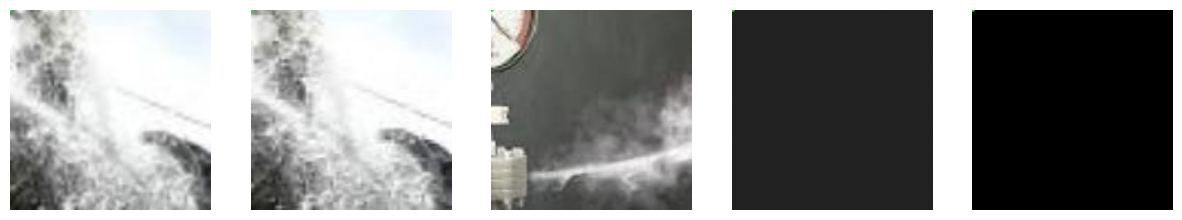

In [ ]:

# Display sample images
def display_images(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        image = images[i]
        label = labels[i]

        # Draw bounding box on the image
        x_center, y_center, width, height = label[1:]
        x1 = int((x_center - width / 2) * 224)
        y1 = int((y_center - height / 2) * 224)
        x2 = int((x_center + width / 2) * 224)
        y2 = int((y_center + height / 2) * 224)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

# Display sample images with bounding boxes
display_images(images, labels)


# MOBILE VNET

In [ ]:

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Define the model architecture
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = Conv2D(256, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Changed activation to softmax

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# MODEL TARINING

In [ ]:
# Train the model
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=24)


Epoch 1/10
42/42 [==============================] - 248s 5s/step - loss: -95699.0391 - accuracy: 0.9253 - val_loss: -4486.0918 - val_accuracy: 0.9563
Epoch 2/10
42/42 [==============================] - 207s 5s/step - loss: -1874407.3750 - accuracy: 0.9492 - val_loss: -10178.1182 - val_accuracy: 0.9563
Epoch 3/10
42/42 [==============================] - 204s 5s/step - loss: -9174015.0000 - accuracy: 0.9492 - val_loss: -792079.8125 - val_accuracy: 0.9563
Epoch 4/10
42/42 [==============================] - 218s 5s/step - loss: -30785114.0000 - accuracy: 0.9492 - val_loss: -4177528.7500 - val_accuracy: 0.9563
Epoch 5/10
42/42 [==============================] - 213s 5s/step - loss: -72861632.0000 - accuracy: 0.9492 - val_loss: -522868.2812 - val_accuracy: 0.9563
Epoch 6/10
42/42 [==============================] - 227s 5s/step - loss: -150062480.0000 - accuracy: 0.9492 - val_loss: -147645072.0000 - val_accuracy: 0.9563
Epoch 7/10
42/42 [==============================] - 229s 5s/step - loss: 

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_images, val_labels)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

8/8 [==============================] - 8s 1s/step - loss: -35641.2305 - accuracy: 0.9563
Validation Loss: -35641.23046875
Validation Accuracy: 0.9563491940498352


# INFERENCE

1/1 [==============================] - 1s 1s/step
Prediction: [[1. 0. 0. 0. 0.]]


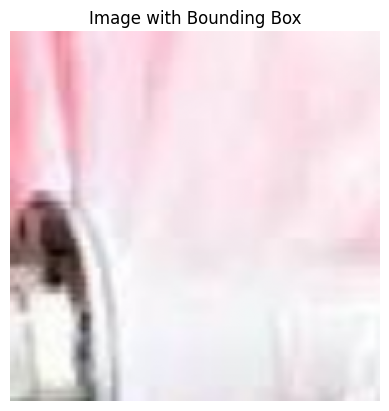

In [ ]:


# Perform inference on new images
def predict_on_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) / 255.0

    # Make prediction
    prediction = model.predict(np.array([image]))
    print("Prediction:", prediction)

    # Visualize the prediction
    plt.imshow(image)
    plt.title('Image with Bounding Box')
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/content/drive/MyDrive/pipeline-leak-prediction.v8i.yolov8/test/images/13_jpg.rf.2506b6b545e557c81d01517e174c2d0e.jpg"  # Replace with the path to your new image
predict_on_image(image_path)